In [44]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import networkx as nx
from pylab import rcParams

plt.style.use('dark_background')

In [2]:
n_samples=5000

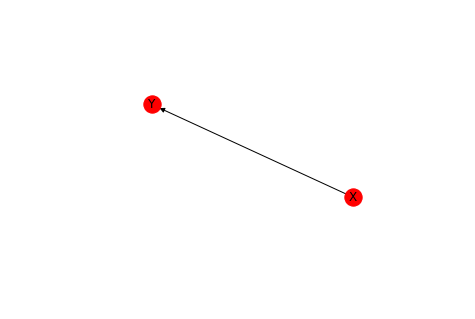

In [3]:
# Graph Models 

G1 = nx.DiGraph()
G1.add_node('X')
G1.add_node('Y')
G1.add_edge('X', 'Y')


G2 = nx.DiGraph()
G2.add_node('X')
G2.add_node('Y')
G2.add_edge('Y', 'X')

G3 = nx.DiGraph()
G3.add_node('X')
G3.add_node('Y')
G3.add_edge('Z', 'Y')
G3.add_edge('Z', 'X')

G4 = nx.DiGraph()
G4.add_node('X')
G4.add_node('Y')
G4.add_edge('Z', 'Y')
G4.add_edge('Z', 'X')
G4.add_edge('X', 'Y')


nx.draw_random(G1, with_labels=True)
  

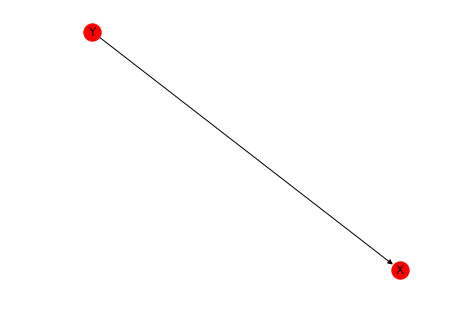

In [4]:
nx.draw_random(G2, with_labels=True)
 

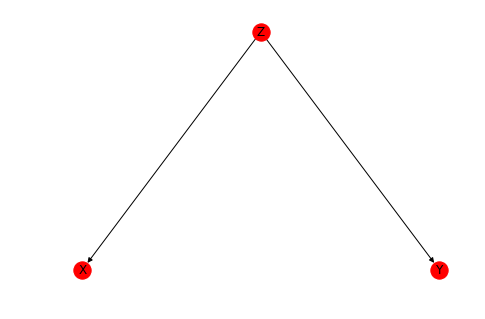

In [5]:
nx.draw_spectral(G3,with_labels=True)
 
 

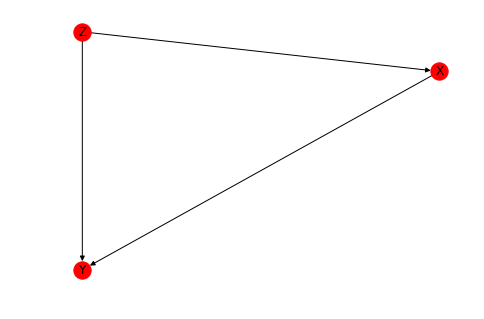

In [6]:
nx.draw_spectral(G4,with_labels=True)



In [7]:
def jointplot(x,y,color,title):
    g = sns.jointplot(x, y, color=color)
    g.annotate(stats.pearsonr)
    g.set_axis_labels(xlabel='x', ylabel='y')
    g.fig.suptitle(title)
    
def kdeplot(y,color,title):
    g = sns.kdeplot(y, color=color, label=title) 

# Three models for generating the data. They 2D gaussian data have same statistics. But the generating process is different. 

1. y = f(x) Direct Causation
2. x = f(y) Reverse Causation
3. x = f1(z), y = f2(z) Confounder 
   

In [8]:
def model1():
    with pm.Model():
        x = pm.Normal('x', mu=0, sd=1)
        y = pm.Deterministic('y',x + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['x'],trace['y']
    
def model2():
    with pm.Model():
        y = pm.Deterministic('y', 1 + 2*pm.Normal('n0', mu=0, sd=1))
        x = pm.Deterministic('x', (y-1)/4 + np.sqrt(3)*pm.Normal('n1', mu=0, sd=1)/2)
        trace = pm.sample(n_samples)
        return trace['x'],trace['y']
    
def model3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        y = pm.Deterministic('y', z + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        x = pm.Deterministic('x', z)
        trace = pm.sample(n_samples)
        return trace['x'],trace['y']
    
    
def model4():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        x = pm.Deterministic('x', z)
        y = pm.Deterministic('y', (z + x)/2 + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        
        trace = pm.sample(n_samples)
        return trace['x'],trace['y']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0, x]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 5027.08draws/s]
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-

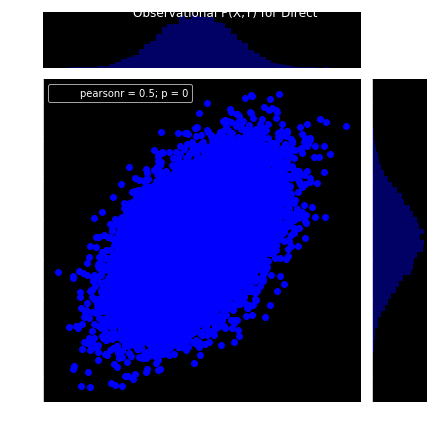

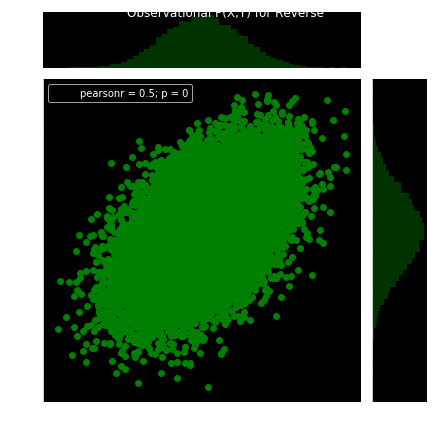

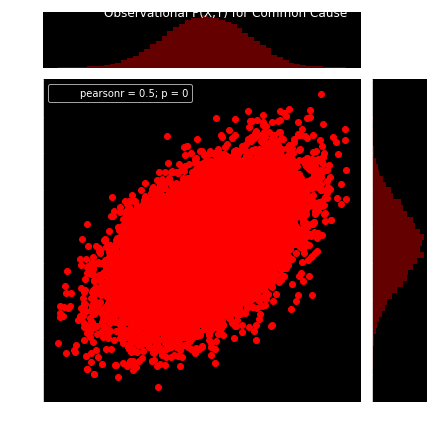

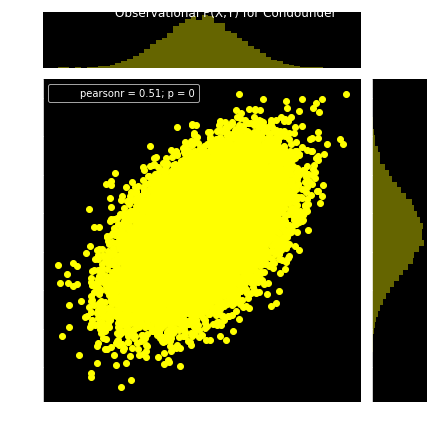

In [9]:
x,y = model1()
jointplot(x, y, color='blue', title='Observational P(X,Y) for Direct')
 
x,y = model2()
jointplot(x, y, color='green', title='Observational P(X,Y) for Reverse')
 
x,y = model3()
jointplot(x, y, color='red', title='Observational P(X,Y) for Common Cause')

x,y = model4()
jointplot(x, y, color='yellow', title='Observational P(X,Y) for Condounder')

# Behavior under observation 
- We now analyze the behaviour of these three models under the observation X=3
- We use again PyMC3 to redefine the models with the conditioning X=3
- (Notice that the models have been slightly reformulated in order to get rid of the Deterministic object which can not be conditoned in PyMC3).


$P(Y | X = 3)$

In [10]:
def model1_observe_X_3():
    with pm.Model():
        x = pm.Normal('x', mu=0, sd=1, observed=3)
        y = pm.Deterministic('y',x + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['y']
    
def model2_observe_X_3():
    with pm.Model():
        y = pm.Deterministic('y', 1 + 2*pm.Normal('n0', mu=0, sd=1))
        x = pm.Normal('x', mu=(y-1)/4.0, sd=3/4.0, observed=3)
        trace = pm.sample(n_samples)
        return trace['y']
    
def model3_observe_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1, observed=3)
        y = pm.Deterministic('y',z + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        x = pm.Deterministic('x', z)
        trace = pm.sample(n_samples)
        return trace['y']

    
def model4_observe_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1, observed=3)
        x = pm.Deterministic('x', z)
        y = pm.Deterministic('y', (z + x)/2 + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        
        trace = pm.sample(n_samples)
        return trace['y']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5830.88draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 5373.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5619.01draws/s]
The acceptance probability does not match the target. It is 0.8815184736114838, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████

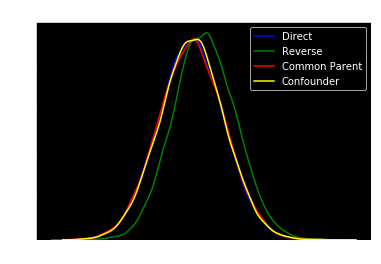

In [11]:
y1 = model1_observe_X_3()
#jointplot(3*np.ones(y1.shape[0]), y1, color='blue', title='Observational P(X,Y | X=3) for model1')

y2 = model2_observe_X_3()
#jointplot(3*np.ones(y2.shape[0]), y2, color='green', title='Observational P(X,Y | X=3) for model2')

y3 = model3_observe_X_3()
#jointplot(3*np.ones(y3.shape[0]), y3, color='red', title='Observational P(X,Y | X=3) for model3')
y4 = model4_observe_X_3()
#jointplot(3*np.ones(y3.shape[0]), y3, color='red', title='Observational P(X,Y | X=3) for model3')


plt.figure()
plt.title('Observational P(Y | X=3)')
kdeplot(y1, color='blue', title='Direct')
kdeplot(y2, color='green', title='Reverse')
kdeplot(y3, color='red', title='Common Parent')
kdeplot(y4, color='yellow', title='Confounder')


plt.legend()

# Behavior under intervention 
- We now analyze the behaviour of these three models under the intervention X=3
- Here we delete all connection to X  


$P(Y | do(X = 3))$

In [12]:
def model1_do_X_3():
    with pm.Model():
        x = 3
        y = pm.Deterministic('y',x + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['y']
    
def model2_do_X_3():
    with pm.Model():
        y = pm.Deterministic('y', 1 + 2*pm.Normal('n0', mu=0, sd=1))
        x = 3
        trace = pm.sample(n_samples)
        return trace['y']
    
def model3_do_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        y = pm.Deterministic('y',z + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        x = 3
        trace = pm.sample(n_samples)
        return trace['y']
    
def model4_do_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        x = 3
        y = pm.Deterministic('y', (z + x)/2 + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        
        trace = pm.sample(n_samples)
        return trace['y']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 5490.63draws/s]
The acceptance probability does not match the target. It is 0.8901674068498201, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5647.61draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0, z]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 4867.92draws/s]
The acceptance probability does not match the target. It is 0.8807614339107556, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS samp

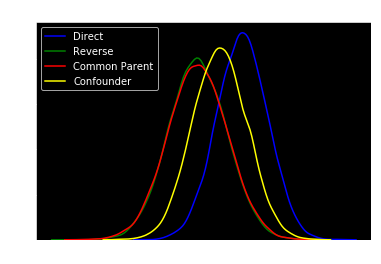

In [13]:
y1 = model1_do_X_3()
#jointplot(3*np.ones(y1.shape[0]), y1, color='blue', title='Interventional P(X,Y | do(X=3)) for model1')

y2 = model2_do_X_3()
#jointplot(3*np.ones(y2.shape[0]), y2, color='green', title='Interventional P(X,Y | do(X=3)) for model2')

y3 = model3_do_X_3()
#jointplot(3*np.ones(y3.shape[0]), y3, color='red', title='Interventional P(X,Y | do(X=3)) for model3')
y4 = model4_do_X_3()
#jointplot(3*np.ones(y3.shape[0]), y3, color='red', title='Interventional P(X,Y | do(X=3)) for model3')


plt.figure()
plt.title('Interventional P(Y | do(X=3))')
kdeplot(y1, color='blue', title='Direct')
kdeplot(y2, color='green', title='Reverse')
kdeplot(y3, color='red',  title='Common Parent')
kdeplot(y4, color='yellow',  title='Confounder')


plt.legend()


# Interventional model evaluated from the observational model via do-calculus

We now analyze evaluate the three models under the intervention X=3. Relying on the observational model transformed via do-calculus. We redefine the models as the models derived by do-calculus and then we observe their behaviour under conditioning X = 3.


In [14]:
def model1_docalculus_X_3():
    with pm.Model():
        x = pm.Normal('x', mu=0, sd=1, observed=3)
        y = pm.Deterministic('y',x + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['y']
    
def model2_docalculus_X_3():
    with pm.Model():
        y = pm.Deterministic('y', 1 + 2*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['y']
    
def model3_docalculus_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        y = pm.Deterministic('y',z + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(n_samples)
        return trace['y']
    
    
def model4_docalculus_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1, observed = 3)
        x = pm.Deterministic('x', z) 
        y = pm.Deterministic('y', (z + x)/2 + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        
        trace = pm.sample(n_samples)
        return trace['y']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5849.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5809.17draws/s]
The acceptance probability does not match the target. It is 0.881079859699574, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0, z]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 4825.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|████████

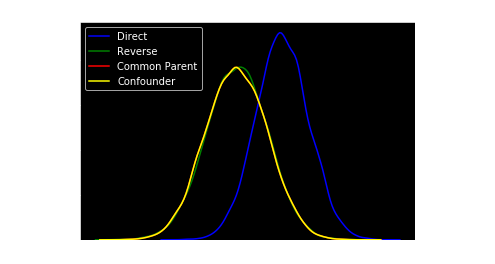

In [15]:
y1 = model1_docalculus_X_3()
#jointplot(3*np.ones(y1.shape[0]), y1, color='blue', title='Interventional P(X,Y | do(X=3)) for model1')

y2 = model2_docalculus_X_3()
#jointplot(3*np.ones(y2.shape[0]), y2, color='green', title='Interventional P(X,Y | do(X=3)) for model2')

y3 = model3_docalculus_X_3()
#jointplot(3*np.ones(y3.shape[0]), y3, color='red', title='Interventional P(X,Y | do(X=3)) for model3')
y4 = model4_docalculus_X_3()


plt.figure()
plt.title('Interventional P(Y | do(X=3)) evaluated from observational data via do-calculus')
kdeplot(y1, color='blue', title='Direct')
kdeplot(y2, color='green', title='Reverse')
kdeplot(y3, color='red', title='Common Parent')
kdeplot(y3, color='yellow', title='Confounder')


plt.legend()

- The estimated distributions match the estimation of P(Y|do(X=3))
- In other words, we can estimate the interventional distribution P(Y|do(X=3)) = P(Y|X=3) 
on the model derived via do-calculus.

# Let's See the difference between P(Y | X = 3) and P(Y | do(X = 3)) for the Direct Causal and the Confounder model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5779.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5572.42draws/s]
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


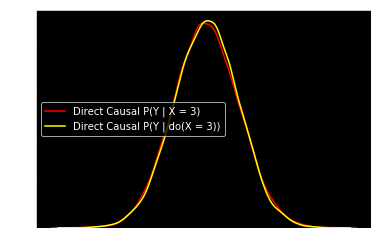

In [16]:
y1 = model1_observe_X_3()
y2 = model1_do_X_3()
kdeplot(y1, color='red', title='Direct Causal P(Y | X = 3)')
kdeplot(y2, color='yellow', title='Direct Causal P(Y | do(X = 3))')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:03<00:00, 5701.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n0, z]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 4878.28draws/s]
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


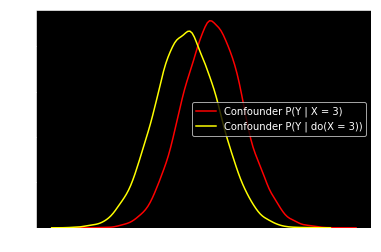

In [17]:
y1 = model4_observe_X_3()
y2 = model4_do_X_3()
kdeplot(y1, color='red', title='Confounder P(Y | X = 3)')
kdeplot(y2, color='yellow', title='Confounder P(Y | do(X = 3))')

# Individual counterfactual

- We now examine individual counterfactuals. 
- To do this, we sample from the model, and then we perform the intervention X=3 while keeping everything else unmodified 


$P(Y | \hat{X}, X = 3)$

In [18]:
def model1_counterfactual_X_3():
    with pm.Model():
        x = pm.Normal('x', mu=0, sd=1)
        y = pm.Deterministic('y',x + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        trace = pm.sample(1000,chains=1)
        
        factual_x = trace['x']
        factual_y = trace['y']
        factual_n0 = trace['n0']
        
        counterfactual_x = 3
        counterfactual_y = counterfactual_x + 1 + factual_n0
        
        return factual_x, factual_y, counterfactual_x, counterfactual_y

def model2_counterfactual_X_3():
    with pm.Model():
        y = pm.Deterministic('y', 1 + 2*pm.Normal('n0', mu=0, sd=1))
        x = pm.Deterministic('x', (y-1)/4 + np.sqrt(3)*pm.Normal('n1', mu=0, sd=1)/2)
        trace = pm.sample(1000 , chains=1)
        
        factual_x = trace['x']
        factual_y = trace['y']
        factual_n0 = trace['n0']
        factual_n1 = trace['n1']
        
        counterfactual_y = factual_y
        counterfactual_x = 3
        
        return factual_x, factual_y, counterfactual_x, counterfactual_y

def model3_counterfactual_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd=1)
        y = pm.Deterministic('y', z + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        x = pm.Deterministic('x',z)
        trace = pm.sample(1000 ,chains=1)
        
        factual_z = trace['x']
        factual_x = trace['x']
        factual_y = trace['y']
        factual_n0 = trace['n0']
        
        counterfactual_y = factual_z + 1 + np.sqrt(3)*factual_n0
        counterfactual_x = 3
        
        return factual_x, factual_y, counterfactual_x, counterfactual_y
    
def model4_counterfactual_X_3():
    with pm.Model():
        z = pm.Normal('z', mu=0, sd = 1)
        x = pm.Deterministic('x', z)
        y = pm.Deterministic('y', (z + x)/2 + 1 + np.sqrt(3)*pm.Normal('n0', mu=0, sd=1))
        
        trace = pm.sample(1000 ,chains=1)
        
        factual_z = trace['x']
        factual_x = trace['x']
        factual_y = trace['y']
        factual_n0 = trace['n0']
        
        counterfactual_x = 3
        counterfactual_y = (factual_z + counterfactual_x)/2 + 1 + np.sqrt(3)*factual_n0
        
        
        return factual_x, factual_y, counterfactual_x, counterfactual_y

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [n0, x]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1307.39it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


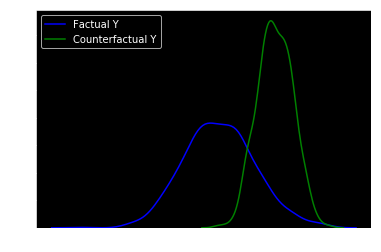

In [19]:
factual_x, factual_y, counterfactual_x, counterfactual_y = model1_counterfactual_X_3()
# print('Causal - Factual (x,y): {0}, {1}'.format(factual_x, factual_y))
# print('Causal - Counterfactual (x,y): {0}, {1}'.format(counterfactual_x, counterfactual_y))

kdeplot(factual_y, color = 'blue', title = 'Factual Y')

kdeplot(counterfactual_y, color = 'green', title = 'Counterfactual Y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [n1, n0]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1296.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


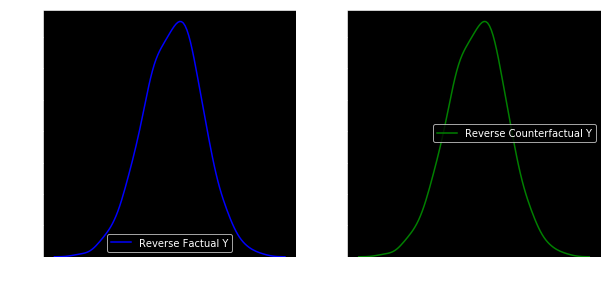

In [20]:
factual_x, factual_y, counterfactual_x, counterfactual_y = model2_counterfactual_X_3()
 
rcParams['figure.figsize'] = 10, 10
plt.subplot(221)


kdeplot(factual_y, color = 'blue', title = 'Reverse Factual Y')
plt.subplot(222)


kdeplot(counterfactual_y, color = 'green', title = 'Reverse Counterfactual Y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [n0, z]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1287.04it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


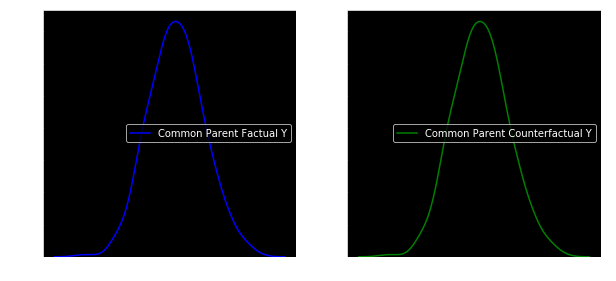

In [21]:
factual_x, factual_y, counterfactual_x, counterfactual_y = model3_counterfactual_X_3()
from pylab import rcParams

rcParams['figure.figsize'] = 10, 10

plt.subplot(221)
kdeplot(factual_y, color = 'blue', title = 'Common Parent Factual Y')
plt.subplot(222)


kdeplot(counterfactual_y, color = 'green', title = 'Common Parent Counterfactual Y')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [n0, z]
Sampling chain 0, 0 divergences: 100%|██████████| 1500/1500 [00:01<00:00, 1282.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


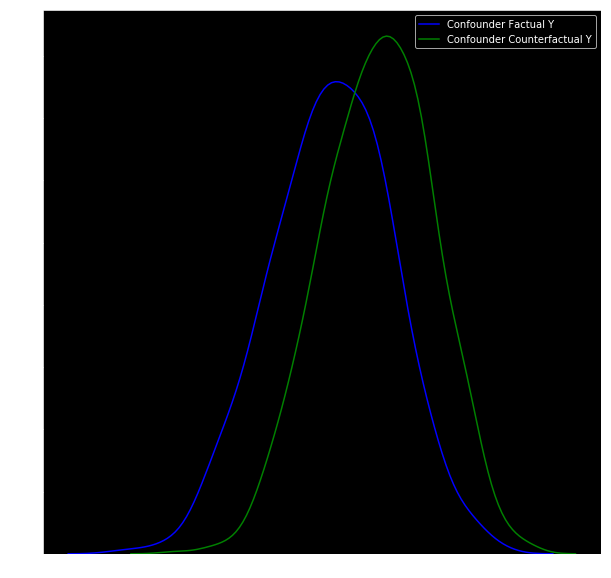

In [22]:
factual_x, factual_y, counterfactual_x, counterfactual_y = model4_counterfactual_X_3()
from pylab import rcParams

rcParams['figure.figsize'] = 10, 10
kdeplot(factual_y, color = 'blue', title = 'Confounder Factual Y')
kdeplot(counterfactual_y, color = 'green', title = 'Confounder Counterfactual Y')

# Causal Discovery

$Y = 2X + N_Y$ with $N_Y, X \overset{ind}{\sim} U$

$X \sim U[-1, 1]$

$N_Y \sim U[-0.4, 0.4]$

In [197]:
rcParams['figure.figsize'] = 10, 10


X = np.random.normal(0, 2, 1000)
Ny = np.random.uniform(-5, 5, 1000)
Y = 2 * X + Ny

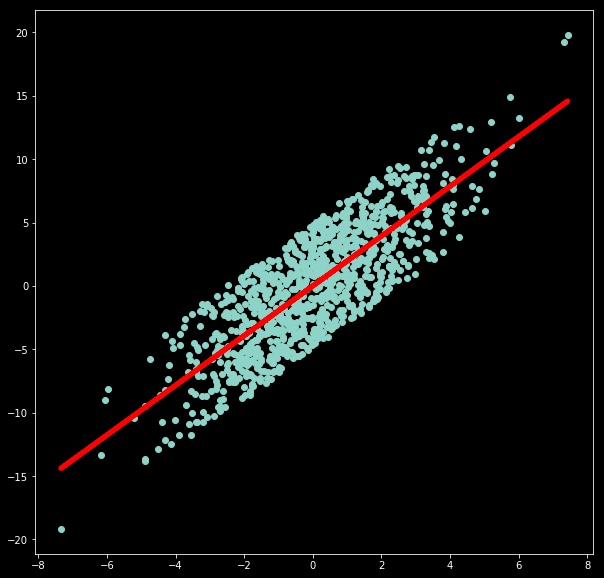

In [198]:
from sklearn.linear_model import LinearRegression
plt.scatter(X, Y)


x, y = X.reshape(-1,1), Y.reshape(-1,1)

plt.plot( x, LinearRegression().fit(x, y).predict(x), 'red', linewidth = 5)


/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


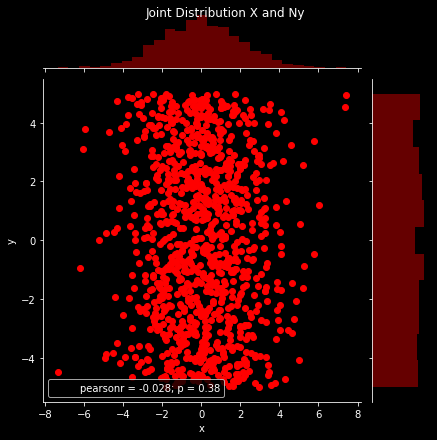

In [199]:
jointplot( X, Ny , color =  'red', title = 'Joint Distribution X and Ny')

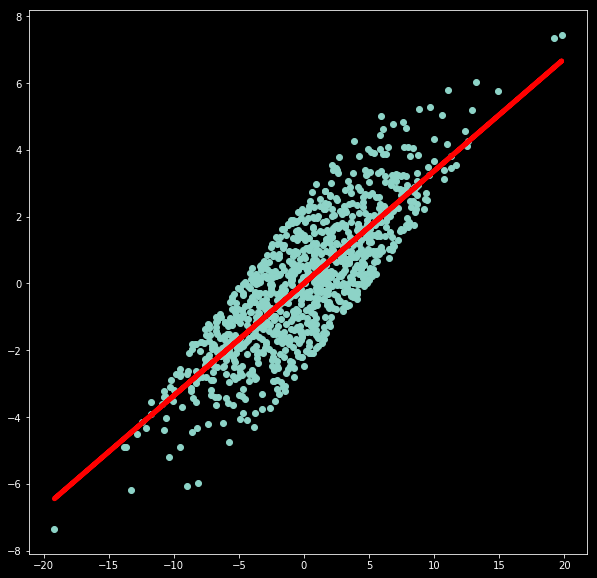

In [200]:
rcParams['figure.figsize'] = 10, 10


plt.scatter(Y, X) 
plt.plot( y, LinearRegression().fit(y, x).predict(y), 'red', linewidth = 5)

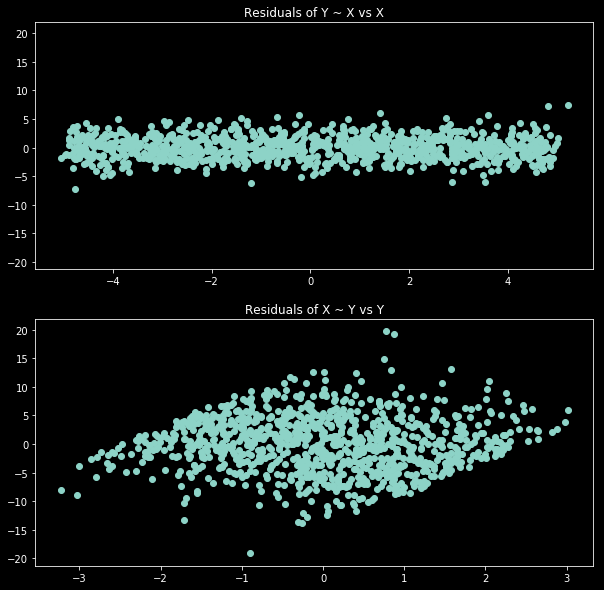

In [201]:
fig, ax = plt.subplots(2,    sharex='row', sharey='col')
ax[0].scatter(y - LinearRegression().fit(x, y).predict(x), x)
 
ax[0].title.set_text("Residuals of Y ~ X vs X")

ax[1].scatter(x- LinearRegression().fit(y, x).predict(y), y, )
ax[1].title.set_text("Residuals of X ~ Y vs Y")




# If Data is generated from Normal Distribution

In [202]:
X = np.random.normal(0, 1, 1000)
Ny = np.random.normal(0.0, 1.0, 1000)
Y = 2 * X + Ny

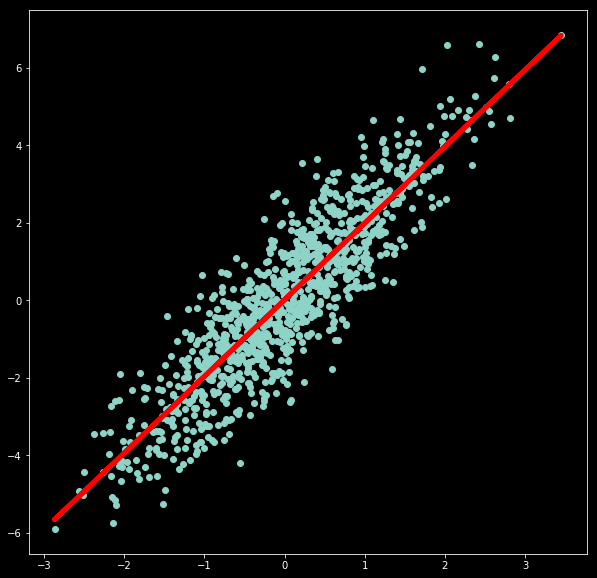

In [203]:
from sklearn.linear_model import LinearRegression
plt.scatter(X, Y)


x, y = X.reshape(-1,1), Y.reshape(-1,1)

plt.plot( x, LinearRegression().fit(x, y).predict(x), 'red', linewidth = 5) 

/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


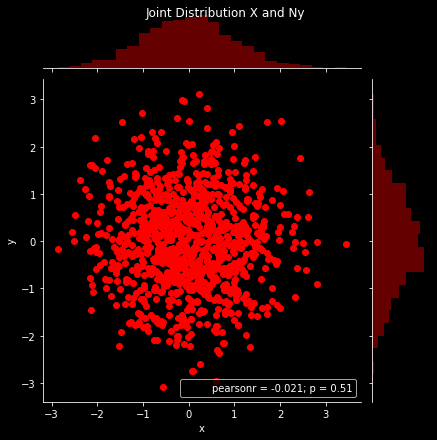

In [204]:
jointplot( X, Ny , color =  'red', title = 'Joint Distribution X and Ny')

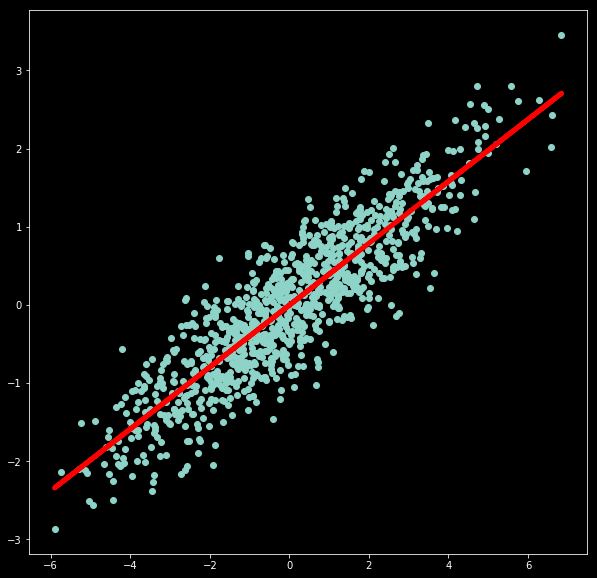

In [205]:
rcParams['figure.figsize'] = 10, 10


plt.scatter(Y, X) 
plt.plot( y, LinearRegression().fit(y, x).predict(y), 'red', linewidth = 5)

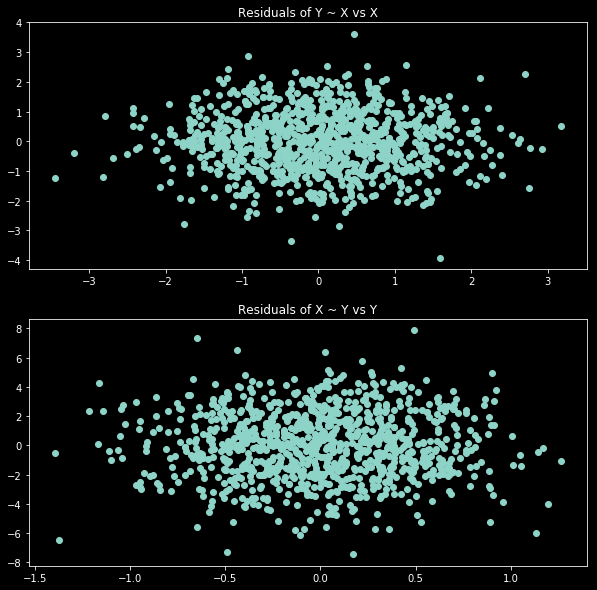

In [190]:
fig, ax = plt.subplots(2 )
ax[0].scatter(y - LinearRegression().fit(x, y).predict(x), x)
 
ax[0].title.set_text("Residuals of Y ~ X vs X")

ax[1].scatter(x- LinearRegression().fit(y, x).predict(y), y )
ax[1].title.set_text("Residuals of X ~ Y vs Y") 